## Class Importation & Summary

In [ ]:
import sys

print(sys.version)
print(sys.executable)
!pip freeze

In [ ]:
!pip install distinctipy -q
!pip install usearch -q

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.cluster import DBSCAN
from scipy.spatial import Delaunay
import random
import itertools
from itertools import chain
from scipy.stats import gaussian_kde
from scipy.spatial.distance import pdist
import math
import warnings
from sklearn.neighbors import KNeighborsClassifier
import distinctipy
import folium
from folium.plugins import FloatImage
import matplotlib.colors as colors
import matplotlib.cm as cm

from dtc_revised import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 31.4 MB/s eta 0:00:00


Check the triangulation_dbscan class structure

### Input Parameters:

**data**: dataframe
- The input dataframe with column names 'x' and 'y' representing the coordinates of the spatial data

**minPts**: int > 1, default=5
- The number of samples in a neighborhood for a point to be considered as a core point. This does not include the point itself.

**kde**: bool, defult=False
- Create initial clusters based on the kernel density estimation of the data before using triangulation-based DBSCAN. It aims at solving the various density problem in complex data.
- If the density of the data is uniformly distributed, this option can be set to False to improve efficiency.

**min_sample**: int > 1, defult = 12
- The number of points in the smallest cluster

**local_std**: float, default = 2.5
- The standard deviation used as threshold to locally remove outlying triangles.

**figsize**: (float, float), default = (8,8)
- Width, height in inches of the final output.

**progress**: bool, defult = False
- Allow the displayment of the detailed algorithm progress.



## Top4 Bank Data Experiments

In [ ]:
top4 = pd.read_csv('top4bank.csv')
top4.rename(columns={'lat': 'y', 'long': 'x'}, inplace=True)
va = top4[top4['State']=='VA']
# va_23 = va[va['Top 4 Bank_2023']==1][['x','y']].reset_index(drop=True)
# va_15 = va[va['Top 4 Bank_2015']==1][['x','y']].reset_index(drop=True)
# va_04 = va[va['Top 4 Bank_2004']==1][['x','y']].reset_index(drop=True)

In [ ]:
deposit = pd.read_csv('deposit.csv')

In [ ]:
deposit_selected_columns = deposit[[
    '2003_DEPSUMBR', '2004_DEPSUMBR', '2005_DEPSUMBR', '2006_DEPSUMBR',
    '2007_DEPSUMBR', '2008_DEPSUMBR', '2009_DEPSUMBR', '2010_DEPSUMBR',
    '2011_DEPSUMBR', '2012_DEPSUMBR', '2013_DEPSUMBR', '2014_DEPSUMBR',
    '2015_DEPSUMBR', '2016_DEPSUMBR', '2017_DEPSUMBR', '2018_DEPSUMBR',
    '2019_DEPSUMBR', '2020_DEPSUMBR', '2021_DEPSUMBR', '2022_DEPSUMBR',
    '2023_DEPSUMBR', 'UNINUMBR'
]]

merged_data = va.merge(deposit_selected_columns, on='UNINUMBR', how='left')

#### VA

In [ ]:
va = va.rename(columns={'lat': 'y', 'long': 'x'})

In [ ]:
import folium

# Define central location for the map
center_lat = sum(latitudes) / len(latitudes)
center_long = sum(longitudes) / len(longitudes)

# Create the folium map
map = folium.Map(location=[center_lat, center_long], zoom_start=4)

# Convert va dataframe's points to a set for quick lookup
va_points = set(zip(va['y'].to_list(), va['x'].to_list()))

# Combine the lists into coordinate pairs and add a circle marker for each pair
for lat, long in zip(latitudes, longitudes):
    if (lat, long) in va_points:
        color = 'red'  # Color points in va as red
    else:
        color = 'blue'  # Color remaining points as blue

    folium.CircleMarker(
        location=[lat, long],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.6
    ).add_to(map)

# Display the map
map


In [ ]:
dataframes = {}

for year in range(2003, 2024):
    df_name = f"va_{str(year)[-2:]}"

    # Create the subset dataframe and reset the index
    dataframes[df_name] = va[va[column_name] == 1][['x', 'y']].reset_index(drop=True)


Start creating initial clusters based on Kernel Density estimation:
[98, 79, 112, 270, 86, 305, 53, 117, 298, 40, 96, 90, 302, 304, 59, 150, 47, 114, 279, 71, 185, 149, 192, 56, 68, 138, 126, 65, 219, 100, 123, 105, 31, 281, 311, 58, 118, 299, 307, 160, 63, 142, 102, 223, 128, 115, 228, 43, 77, 148, 75, 76, 145, 73, 274, 72, 103, 312, 70, 273, 25, 300, 139, 136, 61, 60, 140, 188, 280, 21, 222, 309, 28, 92, 258, 155, 184, 317, 271, 254, 294, 191, 88, 19, 249, 110, 303, 295, 237, 239, 314, 261, 147, 91, 29, 272, 133, 57, 260, 268, 162, 266, 264, 234, 212, 213, 275, 157, 174, 262, 52, 257, 214, 288, 74, 224, 67, 255, 277, 253, 321, 278, 161, 41, 259, 80, 287, 263, 286]
[166, 162, 171, 152, 72, 7, 63, 176, 169, 170, 15, 173, 175, 51, 0, 133, 2, 25, 33, 11, 3, 26, 183, 151, 20, 178, 181, 158, 1, 67, 78, 61, 138, 142, 16, 14, 12, 174, 22, 105, 189, 13, 54, 126, 92, 191, 82, 45, 10, 180, 119, 186, 79, 40, 118, 35, 6, 190, 108, 112, 150, 144, 188, 47, 60, 106, 24, 97, 129, 38, 96, 187, 87, 17,

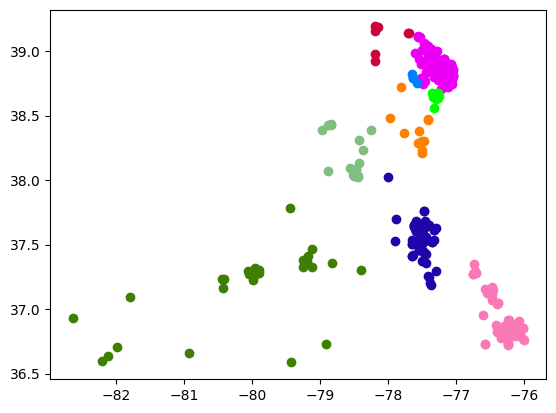

In [ ]:
alg = triangulation_dbscan(dataframes['va_23'], local_std=2.5, figsize =(8,8),kde=True)
clusters_df = alg.tri_dbscan()

In [ ]:
## 2023
def generate_color_dict(values):
    # Define a list of basic color names
    colors = ['gray', 'red', 'pink', 'orange', 'blue', 'yellow', 'black',
              'purple', 'lime', 'cyan', 'magenta', 'green', 'brown', 'teal',
              'gold', 'violet', 'navy', 'indigo', 'salmon', 'olive']
    unique_values = values.unique()
    color_dict = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}
    return color_dict

color_dict = generate_color_dict(clusters_df['est_clust'])

# color_dict = {
#     2: 'gray',
#     14: 'black',
#     13: 'gray',
#     12: 'cyan',
#     1: 'blue',
#     3: 'red',
#     6: 'lime',
#     15: 'magenta',
#     16: 'orange'
# }


latitudes = clusters_df['y'].values.tolist()
longitudes = clusters_df['x'].values.tolist()
labels = clusters_df['est_clust'].values.tolist()  # Get labels as a list

map = folium.Map(location=[38, -78], zoom_start=7)

# Combine the lists into coordinate pairs and add a circle marker for each pair
for lat, long, label in zip(latitudes, longitudes, labels):
    folium.CircleMarker(
        location=[lat, long],
        radius=5,
        color=color_dict[label],  # Use label to pick color
        fill=True,
        fill_color=color_dict[label]  # Use label to pick fill color
    ).add_to(map)

# Display the map
map

## PM2.5 Experiment

In [ ]:
from scipy.io import loadmat
pm25df = loadmat('pm25_usa.mat')
pm25df = pm25df['pm25']
pm25df = pd.DataFrame(pm25df)
df = pm25df[pm25df[0]>12]
df.reset_index(inplace=True, drop=True)
df = df.rename(columns={0: 'winterpm2.5', 1: 'x', 2: 'y', 3: 'prec', 4:'wind', 5:'tmin', 6:'tmax' , 9: 'rhum', 14:'tcdc'})
df_rotated = pd.DataFrame({
    'x': df['y'],
    'y': df['x']
})

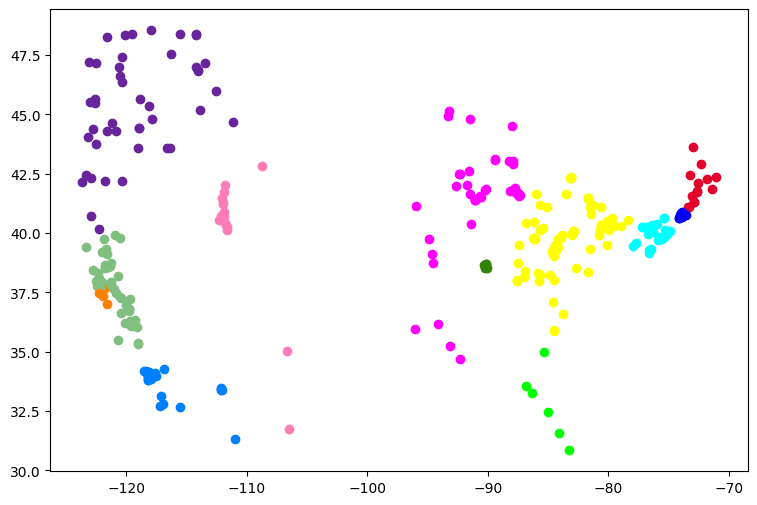

In [ ]:
alg = triangulation_dbscan(df_rotated[['x','y']], local_std = 1.5, figsize = (9,6))
clusters_df = alg.tri_dbscan()

In [ ]:
def generate_color_dict(values):
    # Define a list of basic color names
    colors = ['gray', 'red', 'pink', 'orange', 'blue', 'yellow', 'black','purple', 'lime', 'cyan', 'magenta', 'green']
    unique_values = values.unique()
    color_dict = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}
    return color_dict

color_dict = generate_color_dict(clusters_df['est_clust'])

latitudes = clusters_df['y'].values.tolist()
longitudes = clusters_df['x'].values.tolist()
labels = clusters_df['est_clust'].values.tolist()  # Get labels as a list

map = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=4)

# Combine the lists into coordinate pairs and add a circle marker for each pair
for lat, long, label in zip(latitudes, longitudes, labels):
    folium.CircleMarker(
        location=[lat, long],
        radius=5,
        color=color_dict[label],  # Use label to pick color
        fill=True,
        fill_color=color_dict[label]  # Use label to pick fill color
    ).add_to(map)

# Display the map
map


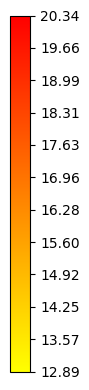

In [ ]:
# Calculate average density for each cluster
average_densities = clusters_df.groupby('est_clust')[0].mean()

# Normalize average densities to 0-1 range
normalized_densities = (average_densities - np.min(average_densities)) / (np.max(average_densities) - np.min(average_densities))

# Create custom color map
cmap = plt.get_cmap('autumn_r')

# Generate color dictionary: {cluster: color}
color_dict = {cluster: colors.rgb2hex(cmap(norm_dens)) for cluster, norm_dens in zip(average_densities.index, normalized_densities)}
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=4)
for lat, lon, label in zip(latitudes, longitudes, labels):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color_dict[label],  # Use label to pick color
        fill=True,
        fill_color=color_dict[label],
    ).add_to(m)


# Assuming all your previous code above this is executed

# Step 1: Create an image of the bar legend using matplotlib
fig, ax = plt.subplots(figsize=(1, 4))
cmap = plt.get_cmap('autumn_r')  # Use the same colormap

norm = colors.Normalize(vmin=average_densities.min(), vmax=average_densities.max())
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='vertical')

# Label the colorbar with average density values
density_ticks = np.linspace(average_densities.min(), average_densities.max(), len(average_densities))
cbar.set_ticks(density_ticks)
cbar.set_ticklabels(['{:.2f}'.format(density) for density in density_ticks])

plt.tight_layout()

# Step 2: Save this image to disk
filename = "colorbar_density.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.close()

# Step 3: Overlay this image on the folium map
img_url = 'colorbar_density.png'  # Local image file path

import base64

def img_to_base64(img_path):
    with open(img_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

img_data = img_to_base64('colorbar_density.png')
img_url_base64 = "data:image/png;base64," + img_data

# Use the Base64 encoded data URL for FloatImage
FloatImage(img_url_base64, bottom=30, left=5).add_to(m)

m